In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import os

root = './drive/My Drive/Colab Notebooks/data/af-classification/training2017/training2017/'

### Read .Mat

In [ ]:
import scipy.io
import numpy as np
import glob

'''
glob.glob(pathname, *, recursive=False)
Return a possibly-empty list of path names that match pathname, which must be a string containing a path specification.

'''
dataDir = root
FS = 200
WINDOW_SIZE = 30*FS

# Loading time serie signals
files = sorted(glob.glob(dataDir+"*.mat"))

trainset = np.zeros((len(files),WINDOW_SIZE))

for f in files:
  record = f[:-4] # '.mat'
  record = record[-6:]
  mat_data = scipy.io.loadmat(f[:-4] + ".mat")
  data = mat_data['val'].squeeze()

mat_data = scipy.io.loadmat(files[0][:-4] + ".mat")
data = mat_data['val'].squeeze()
data = np.nan_to_num(data)
data = data - np.mean(data)
data = data/np.std(data)

### Files to Matrix

In [ ]:
import scipy.io
import numpy as np
import glob
import csv

# Parameters
dataDir = root
FS = 200
WINDOW_SIZE = 30*FS


# Loading time serie signals
files = sorted(glob.glob(dataDir+"*.mat"))
trainset = np.zeros((len(files),WINDOW_SIZE))
count = 0
for f in files:
    record = f[:-4]
    record = record[-6:]
    # Loading
    mat_data = scipy.io.loadmat(f[:-4] + ".mat")
    print('Loading record {}'.format(record))    
    data = mat_data['val'].squeeze()
    # Preprocessing
    # zero mean unit variance raw ECG
    print('Preprocessing record {}'.format(record))       
    data = np.nan_to_num(data) # removing NaNs and Infs
    data = data - np.mean(data)
    data = data/np.std(data)
    trainset[count,:min(WINDOW_SIZE,len(data))] = data[:min(WINDOW_SIZE,len(data))].T # padding sequence
    count += 1
    
## Loading labels    

csvfile = list(csv.reader(open(dataDir+'REFERENCE.csv')))
traintarget = np.zeros((trainset.shape[0],4))
# classes = ['AF','Normal','Others','Noise']
for row in range(len(csvfile)):
    traintarget[row,classes.index(csvfile[row][1])] = 1
            
# Saving both
scipy.io.savemat('trainingset.mat',mdict={'trainset': trainset,'traintarget': traintarget})

In [3]:
train_dir = './drive/My Drive/Colab Notebooks/data/af-classification/trainingset.mat'

In [19]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import scipy.io
import gc
import itertools
from sklearn.metrics import confusion_matrix
import sys
sys.path.insert(0, './preparation')

import pywt

# Keras imports
import keras
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Flatten, Dropout,MaxPooling1D, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras import backend as K

from sklearn.model_selection import train_test_split

In [5]:
matfile = scipy.io.loadmat(train_dir)
X = matfile['trainset']
y = matfile['traintarget']

In [6]:
classes = ['AF','Normal','Others','Noise']
# classes = ['AF','Normal']

sample_fre = len(X[0]) - np.sum(X[0] == 0)
wn_1 = (2*50)/sample_fre
wn_2 = (2*60)/sample_fre
wn_1,wn_2,sample_fre


(0.011111111111111112, 0.013333333333333334, 9000)

In [7]:
af_normal = []
other = []
for i,a in enumerate(y):
  if classes[np.argmax(y[i])] == 'AF' or classes[np.argmax(y[i])] == 'Normal':
    af_normal.append(i)
  else:
    other.append(i)

# X_ and y_ represent the new binary training set
X_ = X[af_normal]
y_ = y[af_normal]

len(X_),len(y_),y_

(5788, 5788, array([[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]]))

In [8]:
a = []
for i in y_:
  if (i == [0, 1, 0, 0]).all():
    a.append([0,1])
  else:
    a.append([1,0])

a = np.array(a)
a.shape

(5788, 2)

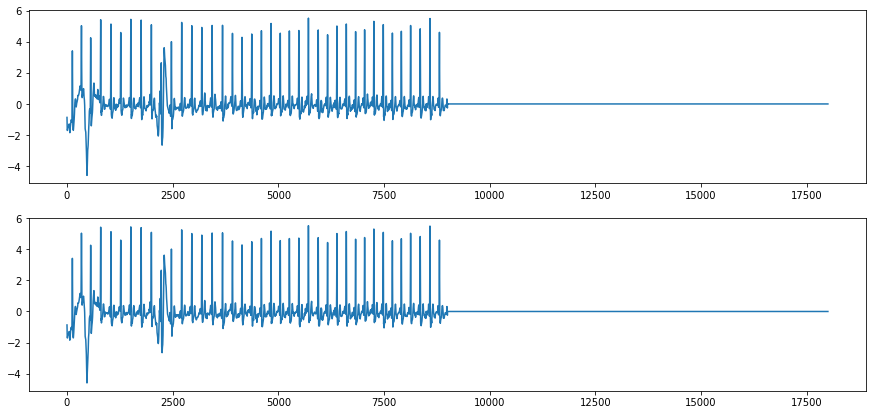

In [9]:
from scipy import signal
b, a = signal.butter(8, 0.8, 'lowpass')
filtedData = signal.filtfilt(b, a, X[0])

plt.figure(figsize=(15,7))
plt.subplot(2,1,1)
plt.plot(filtedData)
plt.subplot(2,1,2)
plt.plot(X[0])

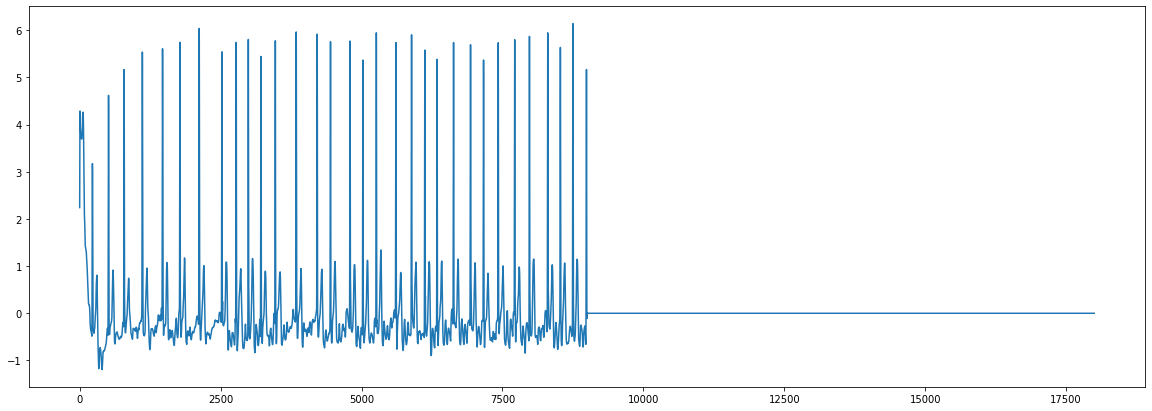

In [10]:
af = []
noice = []
other = []
donknow = []
for i,a in enumerate(y):
  if classes[np.argmax(y[i])] == 'AF':
    af.append(i)
  elif classes[np.argmax(y[i])] == 'Normal':
    noice.append(i)
  elif classes[np.argmax(y[i])] == 'Others':
    other.append(i)
  else:
    donknow.append(i)

plt.figure(figsize=(20,7))
plt.plot(X[af[0]])
# plt.plot(X[af[1]])
# plt.plot(X[af[2]])
# plt.plot(X[noice[0]])
# plt.plot(X[other[0]])
# plt.plot(X[donknow[0]])
plt.show()

### Preprocessing

https://github.com/zzklove3344/ApneaECGAnalysis/blob/master/preprocessOfApneaECG/denoising.py

In [11]:
import pywt
import numpy as np


def denoise_ecg(ecg_segment):
  """
	Remove baseline drafts from ECG signal.
	:param ecg_segment: ecg record, a numpy array.
	:return: denoised ecg record, a numpy array.
	
	Example:
	denoising_ecg = denoise_ecg(raw_ecg)
	"""
  denoising_wd_level = 6
  denoising_wd_wavelet = "db6"
  coffes_set = []
  cA_signal = ecg_segment
  for index_dec in range(denoising_wd_level):
    cA, cD = pywt.dwt(cA_signal, denoising_wd_wavelet)
    coffes_set.append(cD)
    cA_signal = cA
  coffes_set.append(cA_signal)
  coffes_set[denoising_wd_level] = np.zeros(len(coffes_set[denoising_wd_level]))
	
  cA_signal = coffes_set[denoising_wd_level]
  for index_dec in range(denoising_wd_level):
    cD_signal = coffes_set[denoising_wd_level - 1 - index_dec]
    if len(cD_signal) != len(cA_signal):
      cA_signal = np.delete(cA_signal, len(cA_signal) - 1, axis=0)
    cA_signal = pywt.idwt(cA_signal, cD_signal, denoising_wd_wavelet)
  return cA_signal

In [12]:
X_t = []
for i in X:
  X_t.append(denoise_ecg(i))
X_train = np.array(X_t)

# Normalizing data method 2
train_x_ = X_train[:,:8800]
# test_x_ = test_x[:,:8800]

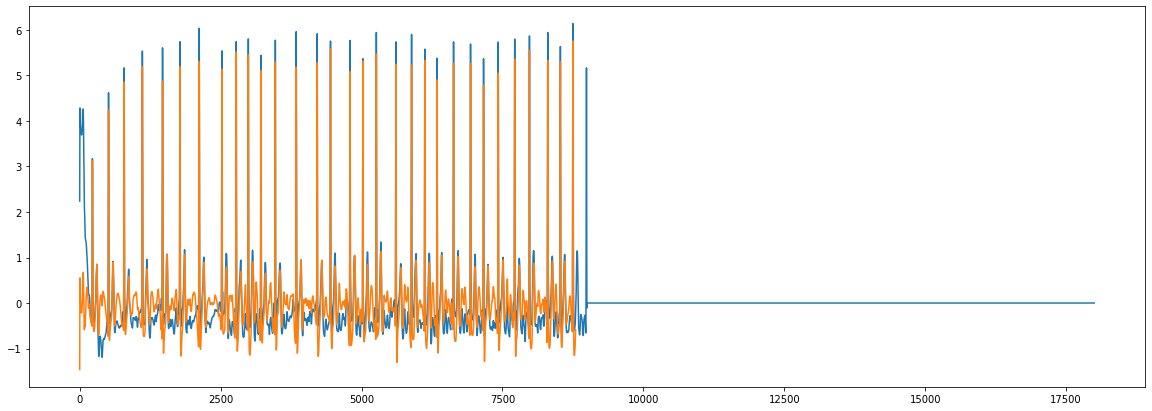

In [13]:
plt.figure(figsize=(20,7))
plt.plot(X[af[0]])
plt.plot(train_x_[af[0]])
plt.show()

The methods come from Yildiz et al. paper, "An expert system for automated recognition of patients with obstructive sleep apnea using electrocardiogram recordings".<br>
Firstly, use wavelet decomposition on ECG signal to six level and get cD1 to cD6, cA6. Secondly, set the cD6 to zero.Lastly, use wavelet reconstruction on cD1 to cD6(zeros) and cA6, and achieve denoising ECG signal.<br>
P wave: atrial depolarization.<br>
QRS complexes: ventricular depolarization.<br>
T wave: ventricular repolarization.<br>
P and T waves range: 0.5hz-10hz.<br>
QRS complex range: 10hz-25hz.<br>

	cD1: 25-50hz
	cD2: 12.5-25hz
	cD3: 6.25-12.5hz
	cD4: 3.125-6.25hz
	cD5: 1.5625-3.125hz
	cD6: 0.78125-1.5625hz
	cD7: 0.390625-0.78125hz
	cA7: 0-0.390625hz

### Callback Function

In [15]:
# Keras imports
import keras
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Flatten, Dropout,MaxPooling1D, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras import backend as K
from keras.callbacks import Callback


class AdvancedLearnignRateScheduler(Callback):    
    '''
   # Arguments
       monitor: quantity to be monitored.
       patience: number of epochs with no improvement
           after which training will be stopped.
       verbose: verbosity mode.
       mode: one of {auto, min, max}. In 'min' mode,
           training will stop when the quantity
           monitored has stopped decreasing; in 'max'
           mode it will stop when the quantity
           monitored has stopped increasing.
   '''
    def __init__(self, monitor='val_loss', patience=0,verbose=0, mode='auto', decayRatio=0.1):
        super(Callback, self).__init__() 
        self.monitor = monitor
        self.patience = patience
        self.verbose = verbose
        self.wait = 0
        self.decayRatio = decayRatio
 
        if mode not in ['auto', 'min', 'max']:
            # warnings.warn('Mode %s is unknown, '
            #               'fallback to auto mode.'
            #               % (self.mode), RuntimeWarning)
            print("Not in mode!!!")
            mode = 'auto'
 
        if mode == 'min':
            self.monitor_op = np.less
            self.best = np.Inf
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = -np.Inf
        else:
            if 'acc' in self.monitor:
                self.monitor_op = np.greater
                self.best = -np.Inf
            else:
                self.monitor_op = np.less
                self.best = np.Inf
 
    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        current_lr = K.get_value(self.model.optimizer.lr)
        print("\nLearning rate:", current_lr)
        if current is None:
            # warnings.warn('AdvancedLearnignRateScheduler'
            #               ' requires %s available!' %
            #               (self.monitor), RuntimeWarning)
            print("WRONG!!")
 
        if self.monitor_op(current, self.best):
            self.best = current
            self.wait = 0
        else:
            if self.wait >= self.patience:
                if self.verbose > 0:
                    print('\nEpoch %05d: reducing learning rate' % (epoch))
                    assert hasattr(self.model.optimizer, 'lr'), \
                        'Optimizer must have a "lr" attribute.'
                    current_lr = K.get_value(self.model.optimizer.lr)
                    new_lr = current_lr * self.decayRatio
                    K.set_value(self.model.optimizer.lr, new_lr)
                    self.wait = 0 
            # self.wait += 1

### Model design

In [21]:
# ResNet based on Rajpurkar
def ResNet_model(WINDOW_SIZE):
    # Add CNN layers left branch (higher frequencies)
    # Parameters from paper
    INPUT_FEAT = 1
    OUTPUT_CLASS = 2    # output classes

    k = 1    # increment every 4th residual block
    p = True # pool toggle every other residual block (end with 2^8)
    convfilt = 64
    convstr = 1
    ksize = 16
    poolsize = 2
    poolstr  = 2
    drop = 0.5
    
    # Modelling with Functional API
    #input1 = Input(shape=(None,1), name='input')
    input1 = Input(shape=(WINDOW_SIZE,INPUT_FEAT), name='input')
    
    ## First convolutional block (conv,BN, relu)
    x = Conv1D(filters=convfilt,
               kernel_size=ksize,
               padding='same',
               strides=convstr,
               kernel_initializer='he_normal')(input1)                
    x = BatchNormalization()(x)        
    x = Activation('relu')(x)  
    
    ## Second convolutional block (conv, BN, relu, dropout, conv) with residual net
    # Left branch (convolutions)
    x1 =  Conv1D(filters=convfilt,
               kernel_size=ksize,
               padding='same',
               strides=convstr,
               kernel_initializer='he_normal')(x)      
    x1 = BatchNormalization()(x1)    
    x1 = Activation('relu')(x1)
    x1 = Dropout(drop)(x1)
    x1 = Conv1D(filters=convfilt,
               kernel_size=ksize,
               padding='same',
               strides=convstr,
               kernel_initializer='he_normal')(x1)
    x1 = MaxPooling1D(pool_size=poolsize,
                      strides=poolstr)(x1)
    # Right branch, shortcut branch pooling
    x2 = MaxPooling1D(pool_size=poolsize,
                      strides=poolstr)(x)
    # Merge both branches
    x = keras.layers.add([x1, x2])
    del x1,x2
    
    ## Main loop
    p = not p 
    for l in range(15):
        if (l%4 == 0) and (l>0): # increment k on every fourth residual block
            k += 1
             # increase depth by 1x1 Convolution case dimension shall change
            xshort = Conv1D(filters=convfilt*k,kernel_size=1)(x)
        else:
            xshort = x        
        # Left branch (convolutions)
        # notice the ordering of the operations has changed        
        x1 = BatchNormalization()(x)
        x1 = Activation('relu')(x1)
        x1 = Dropout(drop)(x1)
        x1 = Conv1D(filters=convfilt*k,
               kernel_size=ksize,
               padding='same',
               strides=convstr,
               kernel_initializer='he_normal')(x1)        
        x1 = BatchNormalization()(x1)
        x1 = Activation('relu')(x1)
        x1 = Dropout(drop)(x1)
        x1 = Conv1D(filters=convfilt*k,
               kernel_size=ksize,
               padding='same',
               strides=convstr,
               kernel_initializer='he_normal')(x1)        
        if p:
            x1 = MaxPooling1D(pool_size=poolsize,strides=poolstr)(x1)                

        # Right branch: shortcut connection
        if p:
            x2 = MaxPooling1D(pool_size=poolsize,strides=poolstr)(xshort)
        else:
            x2 = xshort  # pool or identity            
        # Merging branches
        x = keras.layers.add([x1, x2])
        # change parameters
        p = not p # toggle pooling

    
    # Final bit    
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 
    x = Flatten()(x)
    #x = Dense(1000)(x)
    #x = Dense(1000)(x)
    out = Dense(OUTPUT_CLASS, activation='softmax')(x)
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    #model.summary()
    #sequential_model_to_ascii_printout(model)
    plot_model(model, to_file='model.png')
    return model

# K-fold cross-validation
def model_eval(X,y):
    batch = 64
    epochs = 10  
    rep = 1         # K fold procedure can be repeated multiple times
    Kfold = 5
    # Ntrain = 8528 # number of recordings on training set
    # Ntrain = 5788
    Ntrain = 4051
    Nsamp = int(Ntrain/Kfold) # number of recordings to take as validation        
   
    # Need to add dimension for training
    X = np.expand_dims(X, axis=2)
    # classes = ['AF','Normal','Others','Noise']
    classes = ['AF','Normal']
    Nclass = len(classes)
    cvconfusion = np.zeros((Nclass,Nclass,Kfold*rep))
    cvscores = []       
    counter = 0
    # repetitions of cross validation
    for r in range(rep):
        # print("Rep %d"%(r+1))
        # cross validation loop
        for k in range(Kfold):
            print("Cross-validation run %d"%(k+1))
            # Callbacks definition
            callbacks = [
                # Early stopping definition
                EarlyStopping(monitor='val_loss', patience=3, verbose=1),
                # Decrease learning rate by 0.1 factor
                AdvancedLearnignRateScheduler(monitor='val_loss', patience=1,verbose=1, mode='auto', decayRatio=0.1),            
                # Saving best model
                ModelCheckpoint('weights-best_k{}_r{}.hdf5'.format(k,r), monitor='val_loss', save_best_only=True, verbose=1),
                ]
            # Load model
            model = ResNet_model(WINDOW_SIZE)
            # Save the model in hdf5 format
            model.save("ResNet_30s_34lay_16conv.hdf5")
            
            # split train and validation sets
            # np.range(Ntrain) is generated in the size of Nsamp without replacement
            idxval = np.random.choice(Ntrain, Nsamp, replace=False)
            # bit-wise NOT of the same values between X_train's shape (8528) and idxval (a random given number)
            idxtrain = np.invert(np.in1d(range(X_train.shape[0]),idxval))
            ytrain = y[np.asarray(idxtrain),:]
            Xtrain = X[np.asarray(idxtrain),:,:]         
            Xval = X[np.asarray(idxval),:,:]
            yval = y[np.asarray(idxval),:]
            
            # Train model
            model.fit(Xtrain, ytrain,
                      validation_data=(Xval, yval),
                      epochs=epochs, batch_size=batch,callbacks=callbacks)
            
            # Evaluate best trained model
            model.load_weights('weights-best_k{}_r{}.hdf5'.format(k,r))
            ypred = model.predict(Xval)
            ypred = np.argmax(ypred,axis=1)
            ytrue = np.argmax(yval,axis=1)
            cvconfusion[:,:,counter] = confusion_matrix(ytrue, ypred)
            F1 = np.zeros((2,1))
            for i in range(2):
                F1[i]=2*cvconfusion[i,i,counter]/(np.sum(cvconfusion[i,:,counter])+np.sum(cvconfusion[:,i,counter]))
                print("F1 measure for {} rhythm: {:1.4f}".format(classes[i],F1[i,0]))            
            cvscores.append(np.mean(F1)* 100)
            print("Overall F1 measure: {:1.4f}".format(np.mean(F1)))            
            K.clear_session()
            gc.collect()
            # config = tf.ConfigProto()
            config = tf.compat.v1.ConfigProto()
            config.gpu_options.allow_growth=True            
            # sess = tf.Session(config=config)
            sess = tf.compat.v1.Session(config=config)
            tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
            # K.set_session(sess)
            counter += 1
    # Saving cross validation results 
    scipy.io.savemat('xval_results.mat',mdict={'cvconfusion': cvconfusion.tolist()})  
    return model

### Loading data

In [22]:
# loading data
def loaddata(WINDOW_SIZE):    
    '''
        Load training/test data into workspace
        
        This function assumes you have downloaded and padded/truncated the 
        training set into a local file named "trainingset.mat". This file should 
        contain the following structures:
            - trainset: NxM matrix of N ECG segments with length M
            - traintarget: Nx4 matrix of coded labels where each column contains
            one in case it matches ['AF','Normal','Others','Noise'].
        
    '''
    print("Loading data training set")        
    matfile = scipy.io.loadmat(train_dir)
    X = matfile['trainset']
    y = matfile['traintarget']

    classes = ['AF','Normal','Others','Noise']
    af_normal = []
    other = []
    for i,a in enumerate(y):
      if classes[np.argmax(y[i])] == 'AF' or classes[np.argmax(y[i])] == 'Normal':
        af_normal.append(i)
      else:
        other.append(i)

    # X_ and y_ represent the new binary training set
    X_ = X[af_normal]
    y_ = y[af_normal]

    # Merging datasets    
    X =  X_[:,0:WINDOW_SIZE]

    X_t = []
    print("Denoicing data")
    for i in X:
      X_t.append(denoise_ecg(i))
    X_train = np.array(X_t)

    y_train = []
    for i in y_:
      if (i == [0, 1, 0, 0]).all():
        y_train.append([0,1])
      else:
        y_train.append([1,0])
    
    y_train = np.array(y_train)

    return (X_train, y_train)

### Training

Loading data training set
Denoicing data
Cross-validation run 1
Epoch 1/10
51/51 [==============================] - ETA: 0s - loss: 0.6088 - accuracy: 0.8423
Learning rate: 0.001

Epoch 00001: val_loss improved from inf to 315.81427, saving model to weights-best_k0_r0.hdf5
51/51 [==============================] - 26s 510ms/step - loss: 0.6088 - accuracy: 0.8423 - val_loss: 315.8143 - val_accuracy: 0.8827
Epoch 2/10
51/51 [==============================] - ETA: 0s - loss: 0.3974 - accuracy: 0.8726
Learning rate: 0.001

Epoch 00002: val_loss improved from 315.81427 to 0.84220, saving model to weights-best_k0_r0.hdf5
51/51 [==============================] - 24s 477ms/step - loss: 0.3974 - accuracy: 0.8726 - val_loss: 0.8422 - val_accuracy: 0.7753
Epoch 3/10
51/51 [==============================] - ETA: 0s - loss: 0.3250 - accuracy: 0.8985
Learning rate: 0.001

Epoch 00003: val_loss improved from 0.84220 to 0.49102, saving model to weights-best_k0_r0.hdf5
51/51 [===========================

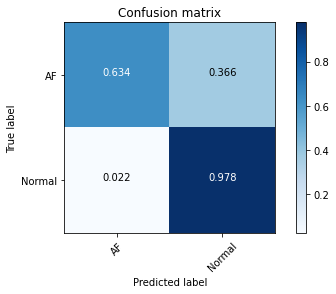

In [23]:
# Confusion Matrix
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    cm = np.around(cm, decimals=3)
    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion.eps', format='eps', dpi=1000)


### Main function of Training ###

config = tf.compat.v1.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
seed = 7
np.random.seed(seed)

# Parameters
FS = 300
WINDOW_SIZE = 30*FS     # padding window for CNN

# Loading data
(X_train,y_train) = loaddata(WINDOW_SIZE)

# Seperating training and test
seed = 2020
np.random.seed(seed)
X_train, x_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=seed)

# Training model
model = model_eval(X_train,y_train)

# Outputing results of cross validation
matfile = scipy.io.loadmat('xval_results.mat')
cv = matfile['cvconfusion']
F1mean = np.zeros(cv.shape[2])
for j in range(cv.shape[2]):
    # classes = ['AF','Normal','Others','Noise']
    classes = ['AF','Normal']
    F1 = np.zeros((2,1))
    for i in range(2):
        F1[i]=2*cv[i,i,j]/(np.sum(cv[i,:,j])+np.sum(cv[:,i,j]))        
        print("F1 measure for {} rhythm: {:1.4f}".format(classes[i],F1[i,0]))
    F1mean[j] = np.mean(F1)
    print("mean F1 measure for: {:1.4f}".format(F1mean[j]))
print("Overall F1 : {:1.4f}".format(np.mean(F1mean)))
# Plotting confusion matrix
cvsum = np.sum(cv,axis=2)
for i in range(2):
    F1[i]=2*cvsum[i,i]/(np.sum(cvsum[i,:])+np.sum(cvsum[:,i]))        
    print("F1 measure for {} rhythm: {:1.4f}".format(classes[i],F1[i,0]))
F1mean = np.mean(F1)
print("mean F1 measure for: {:1.4f}".format(F1mean))
plot_confusion_matrix(cvsum, classes,normalize=True,title='Confusion matrix')

In [ ]:
# Load and apply model
print("Loading model")    
from keras.models import load_model
model = load_model('ResNet_30s_34lay_16conv.hdf5')

print("Applying model ..")    
prob = model.predict(X_test)
ann = np.argmax(prob)
ann

### Predict

Preprocessing recording ..
Loading model
Applying model ..
Record A00286 classified as Others with 100.0% certainty


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

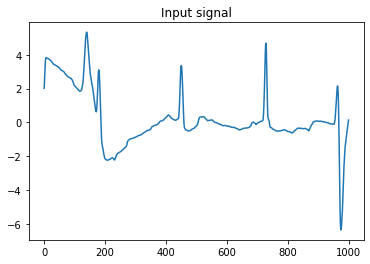

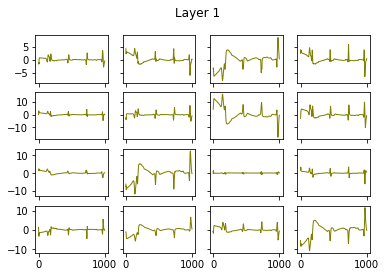

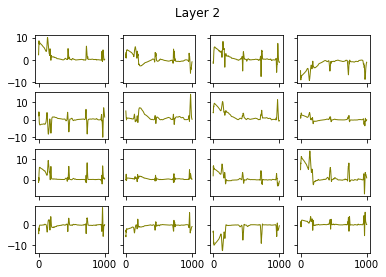

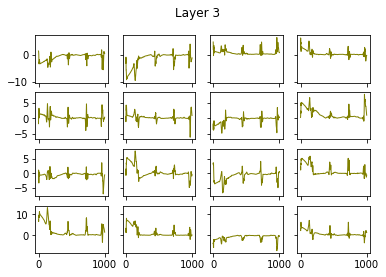

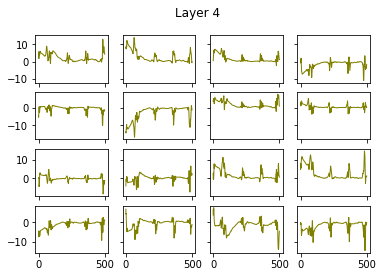

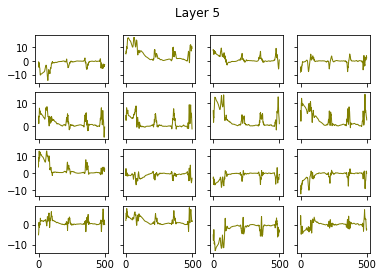

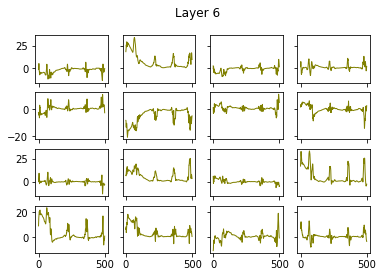

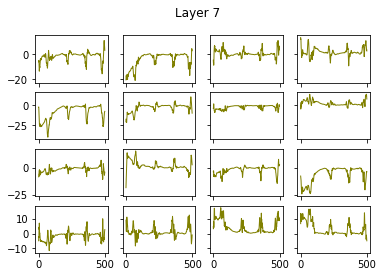

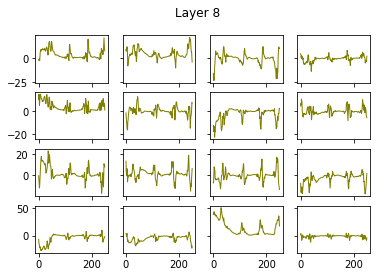

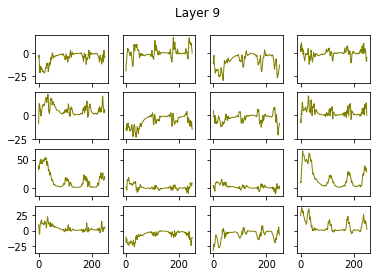

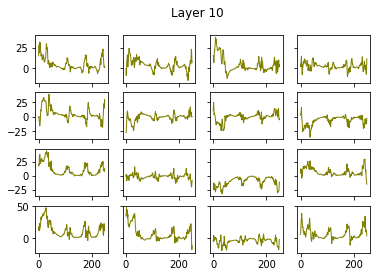

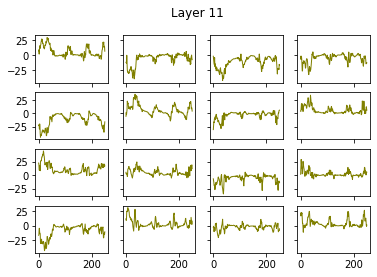

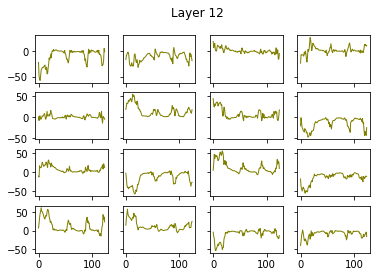

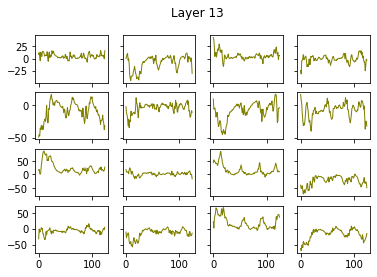

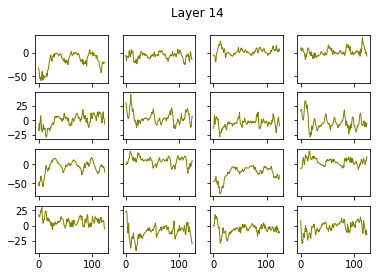

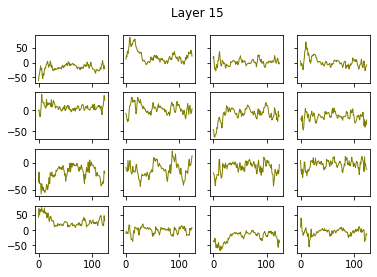

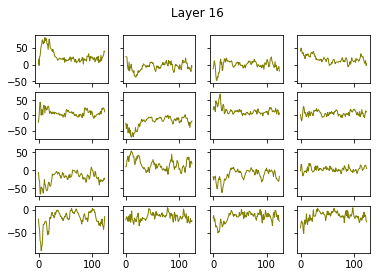

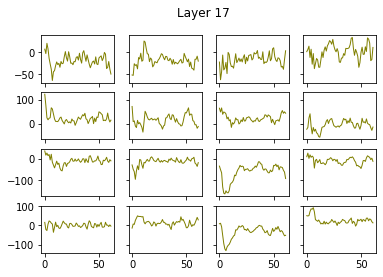

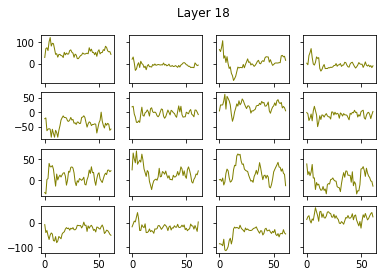

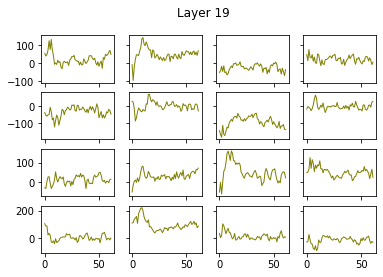

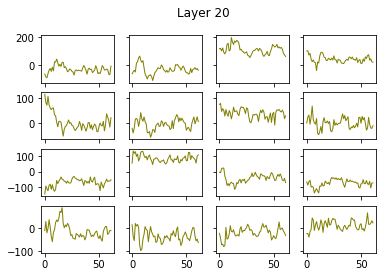

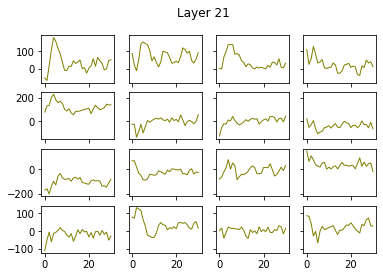

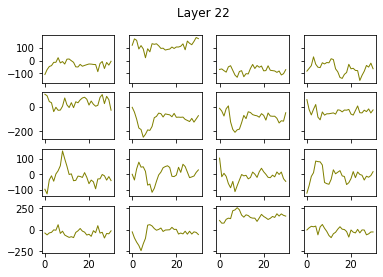

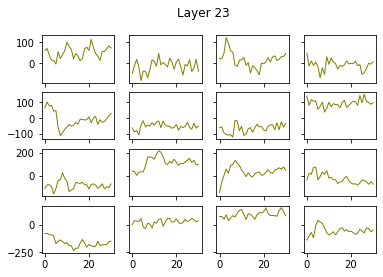

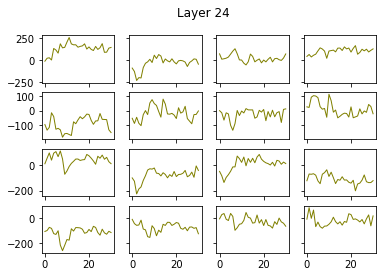

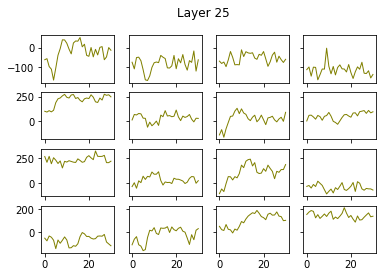

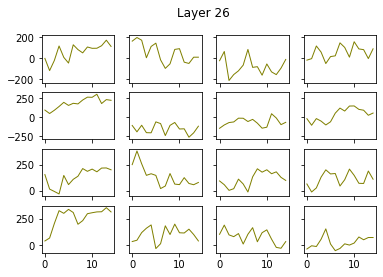

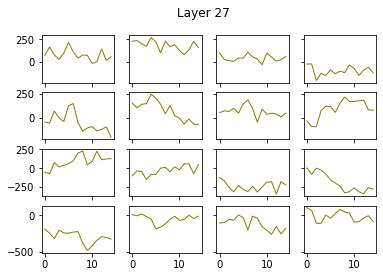

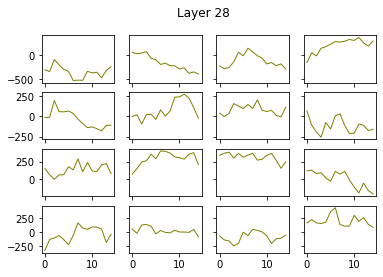

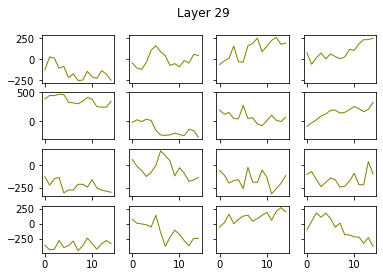

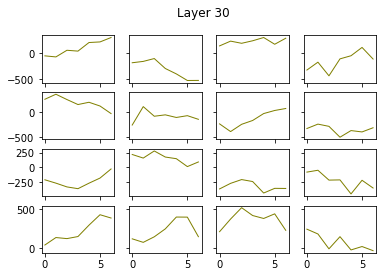

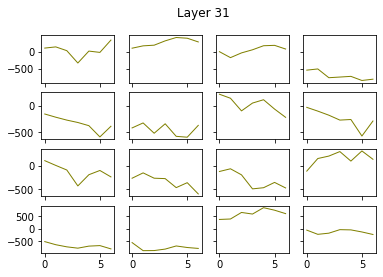

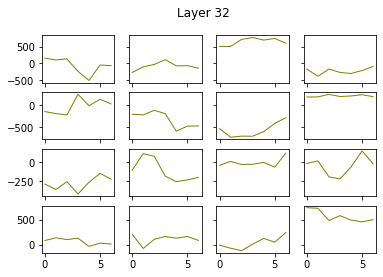

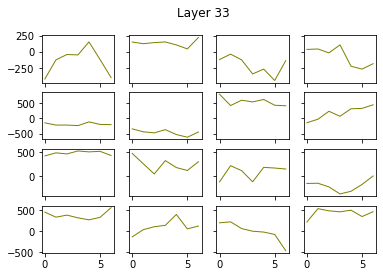

In [ ]:
# Download some random waveform from challenge database
from random import randint
import urllib.request
record = "A{:05d}".format(randint(0, 999))
urlfile = "https://www.physionet.org/physiobank/database/challenge/2017/training/A00/{}.mat".format(record)
local_filename, headers = urllib.request.urlretrieve(urlfile)
html = open(local_filename)
print('Downloading record {} ..'.format(record))
   
# Load data
import scipy.io
mat_data = scipy.io.loadmat(local_filename)
data = mat_data['val']

# Parameters
FS = 300
maxlen = 30*FS
classes = ['AF','Normal']

# Preprocessing data
print("Preprocessing recording ..")    
import numpy as np
X = np.zeros((1,maxlen))
data = np.nan_to_num(data) # removing NaNs and Infs
data = data[0,0:maxlen]
data = data - np.mean(data)
data = data/np.std(data)
X[0,:len(data)] = data.T # padding sequence
data = X
data = np.expand_dims(data, axis=2) # required by Keras
del X


# Load and apply model
print("Loading model")    
from keras.models import load_model
model = load_model('ResNet_30s_34lay_16conv.hdf5')

print("Applying model ..")    
prob = model.predict(data)
ann = np.argmax(prob)
print("Record {} classified as {} with {:3.1f}% certainty".format(record,classes[ann],100*prob[0,ann]))

# Visualising output of first 16 convolutions for some layers
from keras import backend as K
import matplotlib.pyplot as plt
plt.plot(data[0,0:1000,0],)
plt.title('Input signal')
#plt.savefig('layinput.eps', format='eps', dpi=1000) # saving?

for l in range(1,34):#range(1,34):
    Np = 1000
    ## Example of plotting first layer output
    layer_name = 'conv1d_{}'.format(l)
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer_output = layer_dict[layer_name].output
    
    # K.learning_phase() is a flag that indicates if the network is in training or
    # predict phase. It allow layer (e.g. Dropout) to only be applied during training
    get_layer_output = K.function([model.layers[0].input, K.learning_phase()],
                                   [layer_output])
    filtout = get_layer_output([data,0])[0]
    Npnew = int(Np*filtout.shape[1]/data.shape[1])
    fig, ax = plt.subplots(nrows=4, ncols=4, sharex='col', sharey='row')    
    count = 0
    for row in ax:
        for col in row:
            col.plot(range(Npnew), filtout[0,0:Npnew,count],linewidth=1.0,color='olive')
            count += 1
    plt.suptitle('Layer {}'.format(l))
    #plt.savefig('layoutput{}.eps'.format(l), format='eps', dpi=1000) # saving?